In [1663]:
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import TensorDataset
from pathlib import Path

from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot
from utils.attacks import fgsm, pgd

# Attack

### Load pre-trained classifier model

In [1664]:
classifier = SpiralClassifier(2, 2, n_inner_layers=4, width=128)
classifier.load_state_dict(torch.load("../models/spirals/classifier_two_spirals.pt"))
classifier.eval();

### Load "Two Spirals" dataset

In [1665]:
# This cell would generate(!) new points from the two spirals distribution
n_samples   = 20_000
noise       = 3
n_rotations = 1.2

# Generate spiral dataset
# dataset = TensorDataset(*spiral_dataset(n_samples, noise, n_rotations))

In [1666]:
# Instead of re-generating new points from the two spirals distribution all the
# time, we now create a fixed "Two Spirals" dataset and write it to disk.

# X, Y = spiral_dataset(n_samples, noise, n_rotations)
# dataset = { "X": X, "Y": Y }
# torch.save(dataset, "../data/two_spirals/spiral_dataset_20k.pt")

In [1667]:
# Load the "Two Spirals" dataset from disk
loaded_dataset = torch.load("../data/two_spirals/spiral_dataset_20k.pt")

# Extract X and Y from the loaded dataset
X_loaded = loaded_dataset["X"]
Y_loaded = loaded_dataset["Y"]

dataset = TensorDataset(X_loaded, Y_loaded)

### Generate adversarial sample

In [1668]:
# Number of adversarial samples (not yet implemeted for numbers > 1)
n_adv_samples = 1

# How far the adversarial attack may shift the sample along any dimension
eps = 0.2

# Pick an index from the following list of indices that have been found to
# succeed with eps = 1e-1 adversarial samples
# pick = 4
# idx  = [24, 12181, 12443, 12485, 12974, 13319, 15924, 16050, 16360, 19834][pick]

# Or pick an index at random
idx = int(torch.randint(n_samples, (n_adv_samples,)).item())

x = dataset.tensors[0][[idx]]
y = dataset.tensors[1][[idx]].item()

In [1669]:
# Generate adversarial sample
x_adv = fgsm(classifier, x=x, label=y, eps=eps, targeted=False).detach()

## Perform inference on the adversarial sample

In [1670]:
with torch.no_grad():
    pred = classifier(x_adv)
    pred = pred.argmax(axis=1).item()

print(f"Model classifies adversarial attack on sample {idx} as class {pred}.")
print(f"Correct class is {y}.")
print(f"Adversarial attack was {'SUCCESSFUL' if pred != y else 'UNSUCCESSFUL'}.")

Model classifies adversarial attack on sample 14871 as class 0.
Correct class is 1.
Adversarial attack was SUCCESSFUL.


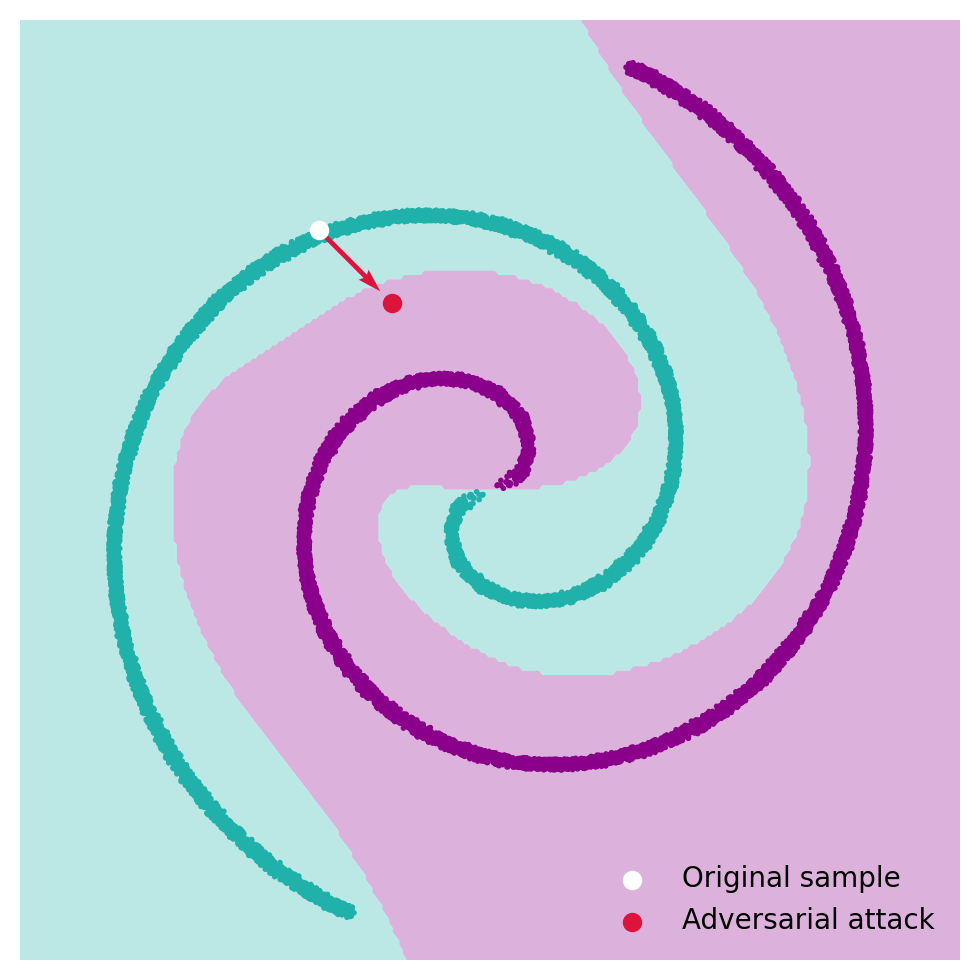

In [1671]:
# Perform inference on all points of a dense pixel grid and visualise the
# decision landscape.
xs, ys, grid_preds = get_grid_predictions(classifier)
colormap = colors.ListedColormap(["darkmagenta", "lightseagreen"])
create_contour_plot(xs, ys, grid_preds, dataset=dataset, colormap=colormap)

# Plot attack vector
vec_attack = x_adv - x
plt.quiver(*x[0], *vec_attack[0], scale_units="xy", scale=1.2, width=0.005, color="crimson")

# Plot the original sample and its adversarial attack
plt.scatter(*x.T, c="white", label="Original sample")

# Plot adversarial sample point
plt.scatter(*x_adv.T, c="crimson",   label="Adversarial attack")

plt.legend(frameon=False, loc="lower right")

# Save figure to disk
# plt.savefig(f"../figures/spiral_attacks/spiral_adv_{idx}.pdf")

# Defence

## Load $\mathcal{M}$-Flow model

In [1672]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform

In [1673]:
# Define M-Flow model
params = {
    "batch_size"         : 512,
    "n_flow_steps"       : 16,   # Depth (#layers)  of the "outer transform"
    "hidden_features"    : 100,  # Width (#neurons) of the "outer transform"
    "n_transform_blocks" : 2     # ???
}
mflow = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(
        dim                  = 2,
        flow_steps           = params["n_flow_steps"],
        hidden_features      = params["hidden_features"],
        num_transform_blocks = params["n_transform_blocks"]
    )
)

mflow.load_state_dict(torch.load("../models/spirals/spiral_mflow_nrotations_1.2_successful_A.pt"))

<All keys matched successfully>

### Defend against adversarial attack

In [1674]:
# Transform adversarial attack sample into latent space
x_latent = mflow.encode(x_adv)

# Project adversarial attack sample onto manifold
x_proj   = mflow.decode(x_latent).detach()

In [1675]:
with torch.no_grad():
    pred_adv = classifier(x_adv)
    pred_adv = pred_adv.argmax(axis=1).item()

    pred_def = classifier(x_proj)
    pred_def = pred_def.argmax(axis=1).item()

att_success = pred_adv != y
def_success = pred_def == y

print("=== ADVERSARIAL ATTACK ===")
print(f"  Model classifies adversarial attack on sample {idx} as class {pred}.")
print(f"  Correct class is {y}.")
print(f"  Adversarial attack was {'SUCCESSFUL. 😱' if att_success else 'UNSUCCESSFUL. 🤷‍♂️'}\n")

print("=== ADVERSARIAL DEFENSE ===")
print(f"  Model classifies back-projection defense as class {pred_def}.")
print(f"  Adversarial defense was {'SUCCESSFUL. 🥳' if def_success else 'UNSUCCESSFUL. 👎'}")

=== ADVERSARIAL ATTACK ===
  Model classifies adversarial attack on sample 14871 as class 0.
  Correct class is 1.
  Adversarial attack was SUCCESSFUL. 😱

=== ADVERSARIAL DEFENSE ===
  Model classifies back-projection defense as class 1.
  Adversarial defense was SUCCESSFUL. 🥳


### Visualise result

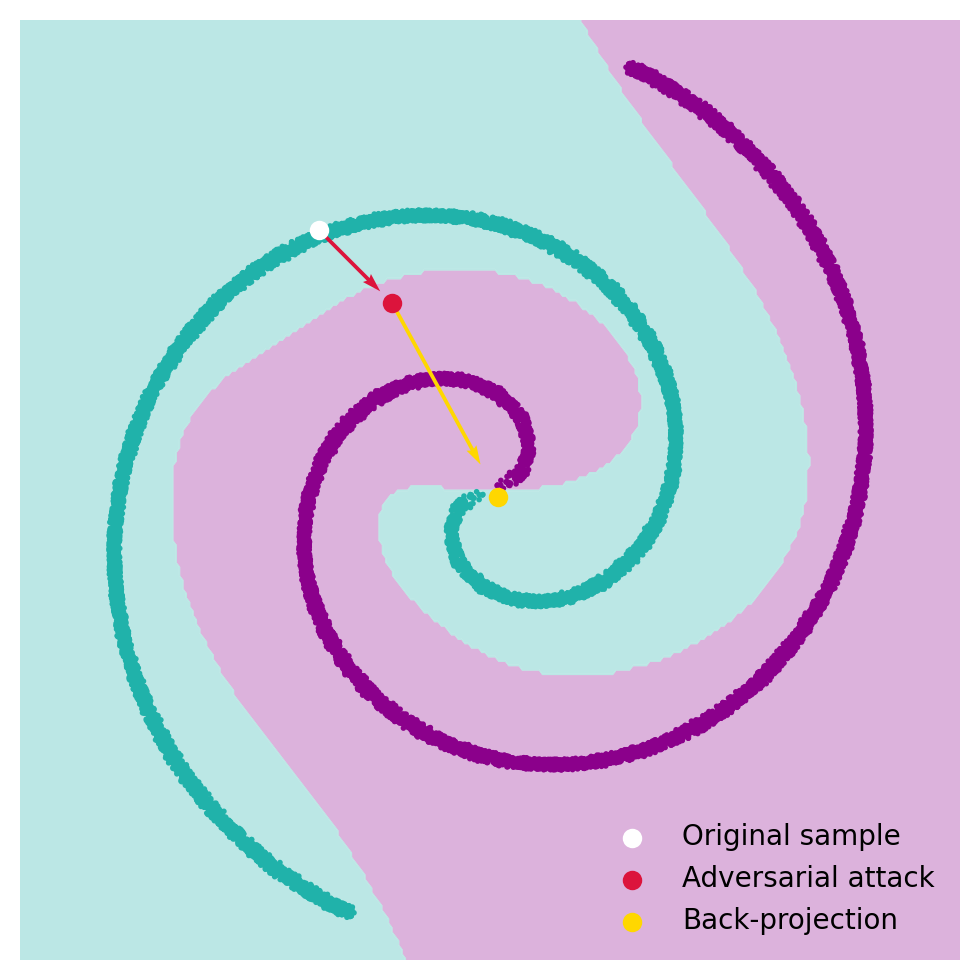

In [1676]:
# Perform inference on all points of a dense pixel grid and visualise the
# decision landscape.
xs, ys, grid_preds = get_grid_predictions(classifier)
colormap = colors.ListedColormap(["darkmagenta", "lightseagreen"])
create_contour_plot(xs, ys, grid_preds, dataset=dataset, colormap=colormap)

# Plot attack vector
vec_attack = x_adv - x
plt.quiver(*x[0], *vec_attack[0], scale_units="xy", scale=1.2, width=4e-3, color="crimson")

# Plot the original sample and its adversarial attack
plt.scatter(*x.T, c="white", label="Original sample")

# Plot defense vector
vec_defense = x_proj - x_adv
plt.quiver(*x_adv[0], *vec_defense[0], scale_units="xy", scale=1.2, width=4e-3, color="gold")

# Plot adversarial sample point
plt.scatter(*x_adv.T, c="crimson", label="Adversarial attack")

# Plot back-projection of adversarial sample onto manifold
plt.scatter(*x_proj.T, c="gold",   label="Back-projection")

plt.legend(frameon=False, loc="lower right")

# Save figure to disk
directory = Path("../figures/spiral_defense/")
directory.mkdir(parents=True, exist_ok=True)

if att_success and def_success:
    pass
    # plt.savefig(directory / f"att_1_def_1_idx_{idx}.pdf")
elif att_success:
    pass
    # plt.savefig(directory / f"att_1_def_0_idx_{idx}.pdf")
elif def_success:
    pass
    plt.savefig(directory / f"att_0_def_1_idx_{idx}.pdf")
else:
    plt.savefig(directory / f"att_0_def_0_idx_{idx}.pdf")